## Heart Stroke Prediction

### 0. Summary

#### Goal

Forecast the likelihood of a patient experiencing a stroke as a function of:
 - presence of diseases,
 - age,
 - gender,
 - smoking status,
 - etc.

#### Dataset

The data is a standard text file consisting of comma separated values, found in various places (for example [here](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset)), with the following features:
 1. gender (object)
 2. age (float)
 3. hypertension (int)
 4. heart_disease (int)
 5. ever_married (object)
 6. work_type (object)
 7. Residence_type (object)
 8. avg_glucose (float)
 9. bmi (float)
 10. smoking_status (object)
 11. stroke (int)

There is a total of 5110 records.

#### Methods

Four methods will be used in attempting to forecast heart strokes:
 1. Logistic Regression
 2. Support Vector Machines
 3. Decision Tree Classifiers
 4. K-Nearest Neighbors

---
### 6. Feature Engineering

#### Preprocess data for feature selection and feature engineering

In [142]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn as skl
import statsmodels.api as smapi
import statsmodels as sms
import scipy as scp
import imblearn as imbl
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [3]:
def plot_kde(
        df_input: pd.DataFrame,
        grid_len: int,
        lim_x: list[int],
        lim_y: list[int],
        data_spread: list[float],
        lbl_mean: list[float],
        lbl_median: list[float],
        title: str,
        ylabl: str,
        xlabl: str,
    ):
 
    data_kde = df_input.to_numpy()
    grid_kde = np.linspace(lim_x[0],lim_x[1],grid_len)
    dens_kde = scp.stats.gaussian_kde(data_kde)(grid_kde)
    val_mean = np.mean(data_kde)
    val_medn = np.median(data_kde)
 
    fig, axs = plt.subplots(figsize=(6,3))
    axs.plot(grid_kde,dens_kde,color='blue',lw=1,linestyle='-')
    axs.plot(data_kde,data_spread[0]+data_spread[1]*np.random.random(data_kde.shape[0]),'.',color='darkgray',alpha=0.1)
    axs.axvline(ymin=0.000,ymax=1.000,x=np.mean(data_kde),  lw=0.5,color='red', label='mean')
    axs.axvline(ymin=0.000,ymax=1.000,x=np.median(data_kde),lw=0.5,color='blue',label='median')
    axs.tick_params(axis='both',direction='in',top=True,right=True)
    axs.set_ylim(lim_y[0],lim_y[1])
    axs.set_ylabel(ylabl)
    axs.set_xlabel(xlabl)
    axs.set_title(title)
    axs.text(val_mean+lbl_mean[0],lbl_mean[1],f'mean={val_mean:.1f}')
    axs.text(val_medn+lbl_median[0],lbl_median[1],f'median={val_medn:.1f}')
    fig.tight_layout()

    return

In [4]:
# 0. read the dataframe
df_orig = pd.read_csv("heart_stroke_prediction.csv")
df_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [5]:
# 1. drop id column, save it for later
df_id = df_orig['id'].copy()
del df_orig['id']
# 2. inspect unique values in each categorical feature
for col in df_orig.columns:
    if df_orig[col].dtype == 'object':
        print(df_orig[col].unique())

['Male' 'Female' 'Other']
['Yes' 'No']
['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
['Urban' 'Rural']
['formerly smoked' 'never smoked' 'smokes' 'Unknown']


In [ ]:
# 3. replace spaces and dashes with underscores
for col in df_orig.columns:
    if df_orig[col].dtype == 'object':
        df_orig[col] = df_orig[col].str.replace('-','_')
        df_orig[col] = df_orig[col].str.replace(' ','_')
# 4. turn all string-typed categorical values to lower-case
for col in df_orig.columns:
    if df_orig[col].dtype == 'object':
        df_orig[col] = df_orig[col].map(lambda x:x.lower())
# 5. change all column titles to lower case
df_orig.columns = df_orig.columns.str.lower()
# 6. take a look at the result 
print(df_orig.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB
None


The numerical `bmi` feature is missing about 4% of the values. These will be imputed at a later step.

In [7]:
# 7. look for isna values
for col in df_orig.columns:
    print(df_orig[col].isna().sum(),df_orig[col].isnull().sum())

0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
201 201
0 0
0 0


This confirms the output of the previous `df.info()` step

In [8]:
# 8. rename all columns to 3 letters - messy looking code wastes time. Don't change 'stroke'
df_orig = df_orig.rename(columns={
        'gender'           :'gen',
        'hypertension'     :'hyp',
        'heart_disease'    :'htd',
        'ever_married'     :'evm',
        'work_type'        :'wtp',
        'residence_type'   :'rtp',
        'avg_glucose_level':'agl',
        'smoking_status'   :'sms',
    }   
)

#### Use K-Nearest Neighbors to impute the missing `bmi` values

In [9]:
# 1. section out the different types found in the dataframe
feat_obj = df_orig.select_dtypes(include='object' ).columns.values.tolist()
feat_int = df_orig.select_dtypes(include='int64'  ).columns.values.tolist()
feat_flt = df_orig.select_dtypes(include='float64').columns.values.tolist()
feat_tgt = [feat_int.pop(feat_int.index('stroke'))] # the target feature is already label encoded via int64 type

In [47]:
# 3. label-encode categorical (object) columns
encoders = {}
df_prep  = pd.DataFrame()
for col in feat_obj:
    encoders[col]   = skl.preprocessing.LabelEncoder()
    curr_data       = df_orig[col][df_orig[col].notnull()].values.reshape(-1,1)
    encoders[col].fit(curr_data)
    df_prep[col]    = encoders[col].transform(curr_data).flatten()

In [48]:
# 4. add the rest of the features to df_prep, convert everything to floats
df_prep = pd.concat([df_prep, df_orig[feat_int],df_orig[feat_flt],df_orig[feat_tgt]],axis=1,join='outer')

In [49]:
# 5. IMPUTATION STEP: impute NaN values via KNN - all ints are now cast as floats here
df_impt = pd.DataFrame(
    skl.impute.KNNImputer(n_neighbors=11).fit_transform(df_prep),
    columns=df_prep.columns
)

In [50]:
# 7. change obj & int features back to int64. rename column
df_impt[feat_obj+feat_int+feat_tgt] = df_impt[feat_obj+feat_int+feat_tgt].astype(int)
df_impt.drop(columns=feat_tgt, inplace=True)
df_trgt = df_orig[feat_tgt]

The current data frames are now present:
* df_impt: contains the imputed `bmi` values, lacks the `stroke` target feature, and non-float columns are LabelEncoded
* df_trgt: contains a single feature, target `stroke`.

#### Build the data frame with one-hot & label-encoded features

In [59]:
# 1. One-Hot encode all the categorical types
onehot   = skl.preprocessing.OneHotEncoder(sparse_output=False)
data     = onehot.fit_transform(df_impt[feat_obj])
df_encd  = pd.DataFrame(data,columns=onehot.get_feature_names_out())
# 2. Add the label-encoded columns found in df_impt, convert to floats
df_encd = pd.concat([df_encd, df_impt[feat_obj].astype('float')], axis=1, join='outer')
print(df_encd.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 21 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   gen_0   5110 non-null   float64
 1   gen_1   5110 non-null   float64
 2   gen_2   5110 non-null   float64
 3   evm_0   5110 non-null   float64
 4   evm_1   5110 non-null   float64
 5   wtp_0   5110 non-null   float64
 6   wtp_1   5110 non-null   float64
 7   wtp_2   5110 non-null   float64
 8   wtp_3   5110 non-null   float64
 9   wtp_4   5110 non-null   float64
 10  rtp_0   5110 non-null   float64
 11  rtp_1   5110 non-null   float64
 12  sms_0   5110 non-null   float64
 13  sms_1   5110 non-null   float64
 14  sms_2   5110 non-null   float64
 15  sms_3   5110 non-null   float64
 16  gen     5110 non-null   float64
 17  evm     5110 non-null   float64
 18  wtp     5110 non-null   float64
 19  rtp     5110 non-null   float64
 20  sms     5110 non-null   float64
dtypes: float64(21)
memory usage: 838.5 KB

#### Generate Numerical Features

In [65]:
def feature_numerical(
        data_col: pd.DataFrame(), # type: ignore
        transforms: list[str],
    ):
    data_transformed = []
    for xfr in transforms:
        if xfr == 'logexp':
            data = np.log(data_col)
            data.name = data_col.name + '_logexp'
            data_transformed.append(data)
        elif xfr == 'logten':
            data = np.log10(data_col)
            data.name = data_col.name + '_logten'
            data_transformed.append(data)
        elif xfr == 'boxcox':
            data = pd.Series(scp.stats.boxcox(data_col)[0])
            data.name = data_col.name + '_boxcox'
            data_transformed.append(data)
        elif xfr == 'yeojon':
            data = pd.Series(scp.stats.yeojohnson(data_col)[0])
            data.name = data_col.name + '_yeojon'
            data_transformed.append(data)
        elif xfr == 'power2':
            data = np.power(data_col,2)
            data.name = data_col.name + '_power2'
            data_transformed.append(data)
        elif xfr == 'power3':
            data = np.power(data_col,3)
            data.name = data_col.name + '_power3'
            data_transformed.append(data)
    dataframe = pd.concat(data_transformed, axis=1)
    return dataframe

In [66]:
# generate numerical features - add to these if needed (these should be enough)
transformations = ['logexp','logten','boxcox','yeojon','power2','power3']
df_flts = pd.DataFrame() # "dataframe floats"
df_flts = pd.concat([
        df_flts,
        feature_numerical(df_impt['bmi'],transformations),
        feature_numerical(df_impt['age'],transformations),
        feature_numerical(df_impt['agl'],transformations),
    ],
    axis=1,
    join='outer'
)

In [67]:
# Apply Robust Scaling - best overall performance for irregularly shaped distros
df_scld = pd.DataFrame()
for col in df_flts:
    temp_col = df_flts[col].values.reshape(-1, 1)
    df_scld[col] = skl.preprocessing.RobustScaler().fit_transform(temp_col).flatten()

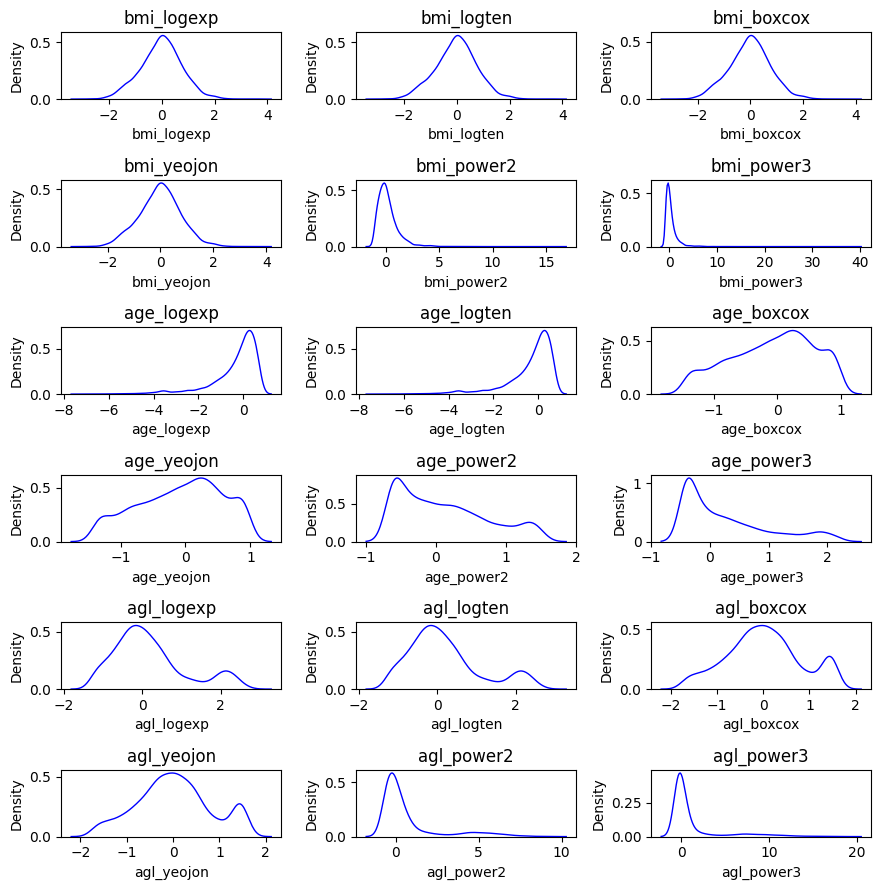

In [68]:
# plot a 6x3 grid of seaborn kernel density estimators of all the rescaled features
fig, axs = plt.subplots(6,3,figsize=(9,9))
for i, col in enumerate(df_scld.columns):
    sns.kdeplot(
        data=df_scld[col],
        ax=axs[i//3,i%3],
        color='blue',
        lw=1,
        linestyle='-'
    )
    axs[i//3,i%3].set_title(col)
plt.tight_layout()


#### Preliminary test on the Feature set

In [72]:
df_work = pd.DataFrame()
df_work = pd.concat([df_work, df_encd, df_scld], axis=1, join='outer')
print(df_work.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 39 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   gen_0       5110 non-null   float64
 1   gen_1       5110 non-null   float64
 2   gen_2       5110 non-null   float64
 3   evm_0       5110 non-null   float64
 4   evm_1       5110 non-null   float64
 5   wtp_0       5110 non-null   float64
 6   wtp_1       5110 non-null   float64
 7   wtp_2       5110 non-null   float64
 8   wtp_3       5110 non-null   float64
 9   wtp_4       5110 non-null   float64
 10  rtp_0       5110 non-null   float64
 11  rtp_1       5110 non-null   float64
 12  sms_0       5110 non-null   float64
 13  sms_1       5110 non-null   float64
 14  sms_2       5110 non-null   float64
 15  sms_3       5110 non-null   float64
 16  gen         5110 non-null   float64
 17  evm         5110 non-null   float64
 18  wtp         5110 non-null   float64
 19  rtp         5110 non-null  

We are now working with the following 4 data-frames:
1. df_encd: one-hot encoded categorical features
2. df_scld: Robust-scaled transformed numerical features
3. df_trgt: The target feature (stroke)
4. df_work: df_encd + df_scld + LabelEncoded features

The main working data frame, `df_work` contains 39 features. The next steps consist of getting first an idea of whether this set can produce a sufficiently high *f1-score*, followed by feature-pruning to increase the density of the data points in the feature-space.

In [73]:
# no corrections for imbalanced data 
class_lr = skl.linear_model.LogisticRegressionCV(cv=5,random_state=42,max_iter=1000)
class_lr.fit(df_work, df_trgt.values.flatten())
y_pred = class_lr.predict(df_work)
print(skl.metrics.classification_report(df_trgt,y_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98      4861
           1       0.00      0.00      0.00       249

    accuracy                           0.95      5110
   macro avg       0.48      0.50      0.49      5110
weighted avg       0.90      0.95      0.93      5110



The support values are substantially imbalanced (4861 vs. 249), and the *f1-score* reflects these levels of support. Add SMOTEENN preprocessing with minority sampling strategy to compensate.

In [74]:
# Balanced data - minority class oversampled
# ----------------------------------------------------------------------------------
# preprocess dataframes with oversampling
smoteenn = imbl.combine.SMOTEENN(random_state=42,sampling_strategy='minority')
df_work_res, df_trgt_res = smoteenn.fit_resample(df_work, df_trgt)
# ----------------------------------------------------------------------------------
# same logistic regression as before
class_lr = skl.linear_model.LogisticRegressionCV(cv=5,random_state=42,max_iter=1000)
class_lr.fit(df_work_res, df_trgt_res.values.flatten())
y_pred = class_lr.predict(df_work_res)
print(skl.metrics.classification_report(df_trgt_res,y_pred))

              precision    recall  f1-score   support

           0       0.87      0.80      0.83      3934
           1       0.84      0.90      0.87      4687

    accuracy                           0.86      8621
   macro avg       0.86      0.85      0.85      8621
weighted avg       0.86      0.86      0.85      8621



As noted in the EDA performed in a separate notebook, the categorical features are all quite imbalanced, and applying SMOTEENN therefore achieves significant improvements in predicting both stroke & no-stroke in patients.

#### Statistical tests

Each numerical feature can be mapped on to an incidence of stroke in the patients. Taken in the aggregate, these will form 2 sets that are distributed in some manner. Comparing these 2 sets with each other, via independent sample tests, provides us with an understanding of their contribution to the effectiveness of the ensuing regression algorithms. So, features will be rejected on the basis of whether or not the *alternate hypothesis (H1)* is accepted in each independent sample test.
* `scipy.stats.ttest_ind`: t-test for independence
    * H0: populations have the same means, differences are due to random error in sampling
    * H1: populations do not have the same means, differences are NOT due to random sampling errors
    * p_value: if < 0.05 accept H1, else accept H0. If H0 is accepted, remove feature from set.
* `scipy.stats.mannwhitneyu`: Mann-Whitney U
    * H0: populations have identical distribution
    * H1: populations do not have an identical distribution
    * p_value: if < 0.05 accept H1, else accept H0. If H0 is accepted, remove feature from set.
* `scipy.stats.bws_test`: Baumgartner-Weiss-Schindler
    * H0: populations have same underlying probability distribution
    * H1: populations do not have same underlying probability distribution
    * p_value: if < 0.05 accept H1, else accept H0. If H0 is accepted, remove feature from set.

In [143]:
# some tests 
sample_tests_num = {}
categories = df_trgt['stroke'].unique()
for ii, col in enumerate(df_scld.columns):
    grp_1 = df_work[df_trgt['stroke'] == categories[0]][col].values
    grp_2 = df_work[df_trgt['stroke'] == categories[1]][col].values
    sample_tests_num[col] = {
        't_test_ind'    : (scp.stats.ttest_ind   (grp_1, grp_2, alternative='two-sided')),
        'mann_whitney_u': (scp.stats.mannwhitneyu(grp_1, grp_2, alternative='two-sided')),
        'bws_test'      : (scp.stats.bws_test    (grp_1, grp_2, alternative='two-sided')),
    }
    break

In [135]:
for key, val in sample_tests_num.items():
    print(key, f'{val["t_test_ind"].pvalue} {val["mann_whitney_u"].pvalue} {val["bws_test"].pvalue}')

bmi_logexp 0.00017916743133529567 0.00014329713067546157 0.0001
bmi_logten 0.00017916743133529614 0.00014366710676952396 0.0001
bmi_boxcox 0.00020004260983729415 0.00014329713067546157 0.0001
bmi_yeojon 0.00019867107296634977 0.00014324619193221017 0.0001
bmi_power2 0.0991147581385004 0.00014364159110603753 0.0001
bmi_power3 0.5474416673177664 0.00014364159110603753 0.0001
age_logexp 1.8028483326284098e-32 3.726634665900011e-71 0.0001
age_logten 1.8028483326284098e-32 3.726634665900011e-71 0.0001
age_boxcox 3.483840762273032e-66 3.726634665900011e-71 0.0001
age_yeojon 4.2510513711305785e-67 3.726634665900011e-71 0.0001
age_power2 4.3137138085416534e-89 3.726634665900011e-71 0.0001
age_power3 3.899599566230408e-96 3.726634665900011e-71 0.0001
agl_logexp 4.777562841831531e-17 3.6403672710893236e-09 0.0001
agl_logten 4.777562841831702e-17 3.6403672710893236e-09 0.0001
agl_boxcox 5.771135842991306e-12 3.6403672710893236e-09 0.0001
agl_yeojon 5.748260436906341e-12 3.6403672710893236e-09 0.0

The p-values returned by the BWS-statistic are all identical to 0.0001, and inspection of the `scipy.stats` code has not revealed anything obvious.
Given that `bws_test` is more rigorous than the other two, interpret this as p-value < 0.05 in all cases, and accept the alternative hypothesis for all transformed numerical features. It is nevertheless interesting to note that in some cases the null hypothesis is sometimes accepted when outliers are not taken into account.

#### Statistical tests: Categorical features